- We only use subtracted images:"CM" and "MLO" which depicts the most of the breast's tissues
- Splitting Images into Train/Test Split

In [ ]:
import os
import pandas as pd
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split

# Paths
csv_path = '../../data/clinical_data.csv'
images_dir = '../../data/images/'
train_dir = '../../data/images/train/'
val_dir = '../..//images/val/'

# Create train and val directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Read the CSV file
df = pd.read_csv(csv_path)

# Filter to only keep rows with "CM" and "MLO" in image_name
df = df[df['Image_name'].str.contains('CM') & df['Image_name'].str.contains('MLO')]
image_names = df['Image_name']
labels = df['Pathology Classification/ Follow up'].replace({'Benign, Normal': 'Benign'})
labels = df['Pathology Classification/ Follow up'].replace({'Malignant, Normal': 'Malignant'})


# Split the data into train and val sets
train_images, val_images, train_labels, val_labels = train_test_split(image_names, labels, test_size=0.2, random_state=42)

# Function to copy images to the respective directories
def copy_images(image_list, label_list, source_dir, dest_dir):
    for image_name, label in zip(image_list, label_list):
        class_dir = os.path.join(dest_dir, str(label))
        os.makedirs(class_dir, exist_ok=True)
        
        src_path = os.path.join(source_dir, image_name+".jpg")
        dest_path = os.path.join(class_dir, image_name+".jpg")
        
        if os.path.exists(src_path):
            if "_L_" in image_name:  # Check if "L" is in the image name
                img = Image.open(src_path)
                img = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)  # Flip horizontally
                img.save(dest_path)  # Save flipped image
                
            else:
                shutil.copy(src_path, dest_path)  # Copy as is

# Copy train images
copy_images(train_images, train_labels, images_dir, train_dir)

# Copy val images
copy_images(val_images, val_labels, images_dir, val_dir)



/Users/marcus/Desktop/Y4S2/DSA4262/DSA4262_Health5/health5/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/marcus/Desktop/Y4S2/DSA4262/DSA4262_Health5/health5/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


pretrained resnet50 loaded
training started...
Epoch 1/8, Loss: 1.0058, Accuracy: 0.5262
Epoch 2/8, Loss: 0.5285, Accuracy: 0.7706
Epoch 3/8, Loss: 0.1490, Accuracy: 0.9751
Epoch 4/8, Loss: 0.0451, Accuracy: 0.9950
Epoch 5/8, Loss: 0.0425, Accuracy: 0.9925
Epoch 6/8, Loss: 0.0461, Accuracy: 0.9900
Epoch 7/8, Loss: 0.0584, Accuracy: 0.9825
Epoch 8/8, Loss: 0.0394, Accuracy: 0.9925
Evaluation started...
Validation Accuracy: 0.6535


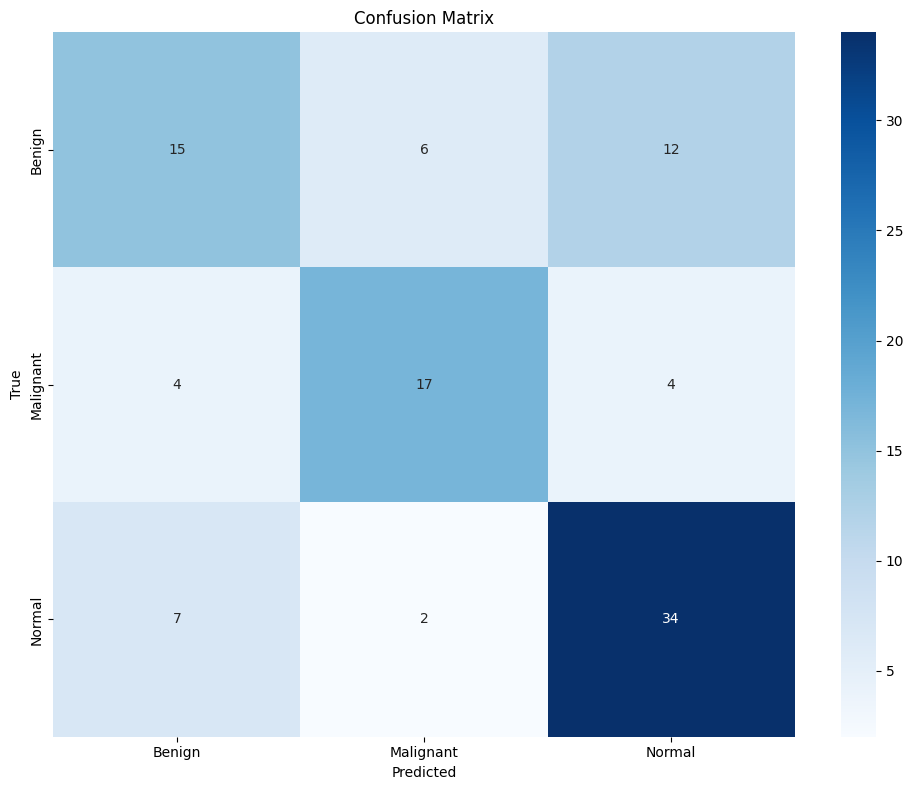

Model saved!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import os
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 8
LEARNING_RATE = 1e-4
NUM_CLASSES = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Transforms (Augmentation and Normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Dataset
train_dataset = datasets.ImageFolder(root="../..data/images/train", transform=transform)
val_dataset = datasets.ImageFolder(root="../../data/images/val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load Pretrained ResNet-50 Model
model = models.resnet50(pretrained=True)
print("pretrained resnet50 loaded")

# Modify the Classifier Head
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training Loop
def train_model():
    model.train()
    for epoch in range(EPOCHS):
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}, Accuracy: {correct/total:.4f}")

def evaluate():
    model.eval()
    correct, total = 0, 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            # Store predictions and labels for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    # Calculate and print accuracy
    accuracy = correct/total
    print(f"Validation Accuracy: {accuracy:.4f}")
    
    # Create and plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Get class names if available, otherwise use indices
    class_names = val_loader.dataset.classes if hasattr(val_loader.dataset, 'classes') else range(len(np.unique(all_labels)))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    return accuracy, cm
# Train and Evaluate
print("training started...")
train_model()
print("Evaluation started...")
evaluate()

# Save Model
torch.save(model.state_dict(), "resnet50_finetuned.pth")
print("Model saved!")


We achieved at accuracy of 0.6535, similar to what was achieved in the study 0.631

### Get F1 score per class

In [12]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, f1_score
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

BATCH_SIZE = 32
EPOCHS = 8
LEARNING_RATE = 1e-4
NUM_CLASSES = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate(model):
    model.eval()
    correct, total = 0, 0
    all_preds = []
    all_labels = []
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    val_dataset = datasets.ImageFolder(root="../../data/images/val", transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            # Store predictions and labels for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    # Calculate and print accuracy
    accuracy = correct/total
    print(f"Validation Accuracy: {accuracy:.4f}")
    
    # Calculate F1 score for each class
    f1_scores = f1_score(all_labels, all_preds, average=None)
    for i, score in enumerate(f1_scores):
        print(f"F1 Score for class {i}: {score:.4f}")
    
    # Create and plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Get class names if available, otherwise use indices
    class_names = val_loader.dataset.classes if hasattr(val_loader.dataset, 'classes') else range(len(np.unique(all_labels)))
    
    # Plot confusion matrix
    print(class_names)
    
    return accuracy, cm, f1_scores

def load_and_evaluate_model(model_path):
    # Load the saved model
    model = models.resnet50()
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 3)  # Assuming 2 classes for the fine-tuned model
    model.load_state_dict(torch.load(model_path))


    # model.to(DEVICE)
    print("Model loaded!")
    
    # Evaluate the model
    accuracy, cm, f1_scores = evaluate(model)
    return accuracy, cm, f1_scores

model_path = "resnet50_finetuned.pth"
load_and_evaluate_model(model_path)

Model loaded!
Validation Accuracy: 0.6535
F1 Score for class 0: 0.5085
F1 Score for class 1: 0.6800
F1 Score for class 2: 0.7312
['Benign', 'Malignant', 'Normal']


(0.6534653465346535,
 array([[15,  6, 12],
        [ 4, 17,  4],
        [ 7,  2, 34]]),
 array([0.50847458, 0.68      , 0.7311828 ]))

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, f1_score
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

BATCH_SIZE = 32
EPOCHS = 8
LEARNING_RATE = 1e-4
NUM_CLASSES = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate(model):
    model.eval()
    correct, total = 0, 0
    all_preds = []
    all_labels = []
    all_logits = []
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    val_dataset = datasets.ImageFolder(root="../../data/images/val", transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            all_logits+=outputs.tolist()
            _, preds = torch.max(outputs, 1)
            
            # Store predictions and labels for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    # Calculate and print accuracy
    accuracy = correct/total
    print(f"Validation Accuracy: {accuracy:.4f}")
    
    # Calculate F1 score for each class
    f1_scores = f1_score(all_labels, all_preds, average=None)
    for i, score in enumerate(f1_scores):
        print(f"F1 Score for class {i}: {score:.4f}")
    
    # Create and plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Get class names if available, otherwise use indices
    class_names = val_loader.dataset.classes if hasattr(val_loader.dataset, 'classes') else range(len(np.unique(all_labels)))
    
    # Plot confusion matrix
    print(class_names)
    
    return accuracy, cm, f1_scores, all_logits

def load_and_evaluate_model(model_path):
    # Load the saved model
    model = models.resnet50()
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 3)  # Assuming 2 classes for the fine-tuned model
    model.load_state_dict(torch.load(model_path))


    # model.to(DEVICE)
    print("Model loaded!")
    
    # Evaluate the model
    accuracy, cm, f1_scores, all_logits = evaluate(model)
    return accuracy, cm, f1_scores, all_logits

model_path = "../../model/resnet50_finetuned.pth"
accuracy, cm, f1_scores, all_logits = load_and_evaluate_model(model_path)

Model loaded!
Validation Accuracy: 0.6535
F1 Score for class 0: 0.5085
F1 Score for class 1: 0.6800
F1 Score for class 2: 0.7312
['Benign', 'Malignant', 'Normal']


In [12]:
all_logits
import json
with open('finetuned_resnet50_logits.json', 'w') as f:
  json.dump(all_logits, f, indent=2)